In [1]:
#%pylab qt
%pylab inline
#%pylab notebook
from __future__ import division # use so 1/2 = 0.5, etc.
import ssd
import scipy.signal as signal
from IPython.display import Image, SVG

Populating the interactive namespace from numpy and matplotlib


In [2]:
pylab.rcParams['savefig.dpi'] = 100 # default 72
#pylab.rcParams['figure.figsize'] = (6.0, 4.0) # default (6,4)
%config InlineBackend.figure_formats=['png'] # default for inline viewing
#%config InlineBackend.figure_formats=['svg'] # SVG inline viewing
#%config InlineBackend.figure_formats=['pdf'] # render pdf figs for LaTeX

# Introduction to Python and the Jupyter Notebook

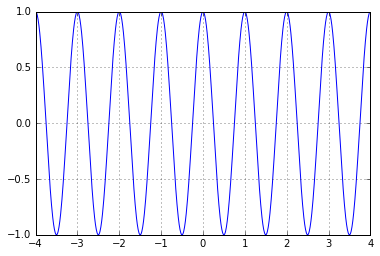

In [46]:
t = arange(-4,4,.01)
x = cos(2*pi*t)
plot(t,x)

grid()

# Rectangle and Triangle Pulses Defined
Before showing more examples, consider some familiar signal primitives in your signals and systems background.

To see these defined in the text see in particular Append F.5 (p.727) in the table of Fourier transform pairs.

**Rectangle**
\begin{align}
	\Pi\Big(\frac{t}{\tau}\Big) &= \begin{cases}
		1, & |t| \leq \tau/2 \\
		0, & \text{otherwise}
	\end{cases}
\end{align}
**Triangle**
\begin{align}
	\Lambda\Big(\frac{t}{\tau}\Big) &= \begin{cases}
		1-|t/\tau| \leq \tau/2, & |t|\leq \tau \\
		0, & \text{otherwise}
	\end{cases}
\end{align}
To more readily play with these function represent them numerically in Python. The module `ssd.py` has some waveform primitive to help.

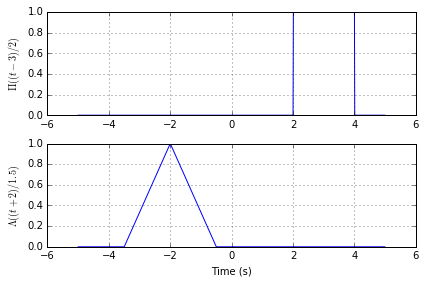

In [6]:
%matplotlib inline
#%matplotlib notebook
t = arange(-5,5,.01)
x_rect = ssd.rect(t-3,2)
x_tri = ssd.tri(t+2,1.5)
subplot(211)
plot(t,x_rect)
grid()
ylabel(r'$\Pi((t-3)/2)$');
subplot(212)
plot(t,x_tri)
grid()
xlabel(r'Time (s)')
ylabel(r'$\Lambda((t+2)/1.5)$');
tight_layout()

* Consider an interactive version of the above:

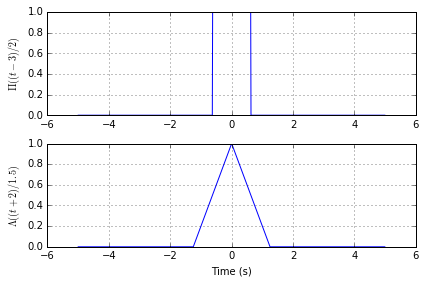

In [7]:
# Make an interactive version of the above
from IPython.html.widgets import interact

def pulses_plot(D1,D2,W1,W2):
    t = arange(-5,5,.01)
    x_rect = ssd.rect(t-D1,W1)
    x_tri = ssd.tri(t-D2,W2)
    subplot(211)
    plot(t,x_rect)
    grid()
    ylabel(r'$\Pi((t-3)/2)$');
    subplot(212)
    plot(t,x_tri)
    grid()
    xlabel(r'Time (s)')
    ylabel(r'$\Lambda((t+2)/1.5)$');
    tight_layout()
    
interact(pulses_plot,D1 = (-3,3,.5), D2 = (-3,3,.5), W1 = (0.5,2,.25), W2 = (0.5,2,.25));

## More Signal Plotting
The basic pulse shapes (primitives) defined in the module `ssd.py` are very useful for working Text 2.13a &d, but there are also times when you need a custom piecewise function.

### Simple Cases:
Consider plotting

* $x_1(t) = \sin(2\pi\cdot 5t) \Pi((t-2)/2)$ for $0\leq t \leq 10$
* $x_2(t) = \sum_{n=-\infty}^\infty = \Pi((t-5n)/1)$ for $-10 \leq t \leq 10$

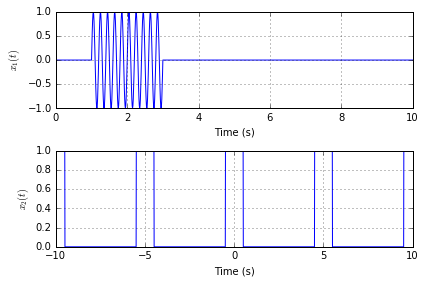

In [8]:
t1 = arange(0,10+.01,.01) # arange stops one step size less than the upper limit
x1 = sin(2*pi*5*t1)* ssd.rect(t1-2,2)
subplot(211)
plot(t1,x1)
xlabel(r'Time (s)')
ylabel(r'$x_1(t)$')
grid()
t2 = arange(-10,10,.01)
# Tweak mod() to take on negative values
x2 = ssd.rect(mod(t2+2.5,5)-2.5,1)
subplot(212)
plot(t2,x2)
xlabel(r'Time (s)')
ylabel(r'$x_2(t)$')
grid()
tight_layout()

### Custom Piecewise:
A custom piecewise function is a direct and to the point way of getting a more complex function plotted. Consider plotting:
\begin{align}
    x_3(t) = \begin{cases}
        1 + t^2, & 0\leq t \leq 3 \\
        \cos(2\pi\cdot5\cdot t) & 3 < t \leq 5 \\
        0, & \text{otherwise}
    \end{cases}
\end{align}
for $-2\leq t \leq 6$.

In [9]:
def x3_func(t):
    """
    Create a piecewise function for plotting x3
    """
    x3 = zeros_like(t)
    for k,tk in enumerate(t):
        if tk >= 0 and tk <= 3:
            x3[k] = 1 + tk**2
        elif tk > 3 and tk <= 5:
            x3[k] = cos(2*pi*5*tk)
    return x3

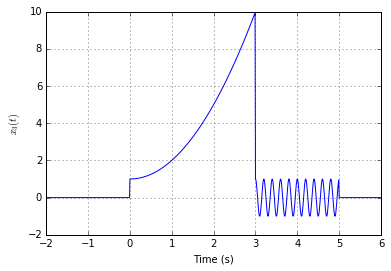

In [10]:
t3 = arange(-2,6+.01,.01)
x3 = x3_func(t3)
plot(t3,x3)
xlabel(r'Time (s)')
ylabel(r'$x_3(t)$')
xlim([-2,6])
grid()

# Energy and Power Signals

The general definitions are:
\begin{align}
		E &\overset{\Delta}{=} \lim_{T\rightarrow\infty} \int_{-T}^T |x(t)|^2\, dt = \int_{-\infty}^\infty |x(t)|^2\, dt \\
		P &\overset{\Delta}{=} \lim_{T\rightarrow\infty}\frac{1}{2T} \int_{-T}^T |x(t)|^2\, dt
\end{align}
For the case of a periodic signal, you can take the definition of $P$ above and reduce the calculation down to
\begin{align}
    P = \frac{1}{T} \int_{t_0}^{t_0+T} |x(t)|^2\, dt
\end{align}
where $t_0$ can be any convenient value.

Consider the waveform of Text problem 2.14b
\begin{align}
    x_2(t) = \sum_{n=-\infty}^\infty \Lambda\Big(\frac{t-3n}{2}\Big)
\end{align}

You can create an approximation to the waveform over a finite number of periods by doing a little programming:

In [11]:
def periodic_tri(t,tau,T,N):
    """
    Approximate x2(t) by running the sum index from -N to +N.
    The period is set by T and tau is the tri pulse width
    parameter (base width is 2*tau).
    
    Mark Wickert January 2015
    """
    x = zeros_like(t)
    for n in arange(-N,N+1):
        x += ssd.tri(t-T*n,tau)
    return x

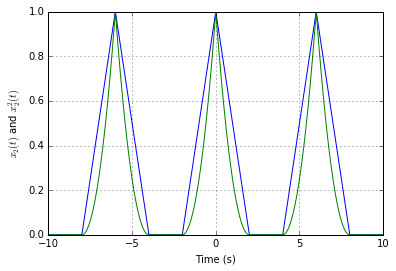

In [12]:
t = arange(-10,10,.001)
x = periodic_tri(t,2,6,10)
plot(t,x)
plot(t,abs(x)**2)
grid()
#xlim([-5,5])
xlabel(r'Time (s)')
ylabel(r'$x_2(t)$ and $x_2^2(t)$');

For the power calculation create a time array that runs over exactly one period. Below is the case for the original problem statement.

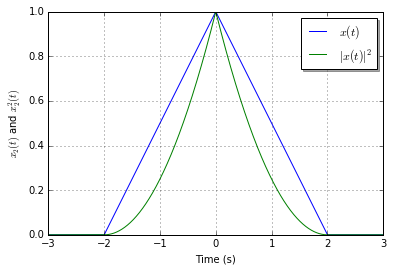

In [13]:
T0 = 6
tp = arange(-T0/2,T0/2+.001,.001)
xp = periodic_tri(tp,2,T0,5)
plot(tp,xp)
plot(tp,abs(xp)**2)
legend((r'$x(t)$', r'$|x(t)|^2$'),loc='best',shadow=True)
grid();
xlim([-T0/2,T0/2])
xlabel(r'Time (s)')
ylabel(r'$x_2(t)$ and $x_2^2(t)$');

A simple numerical approximation to the integral
\begin{align}
    P = \frac{1}{T}\int_0^T |x_b(t)|^2\, dt
\end{align}
is shown below:

In [14]:
#Power calculation
Px2 = (1/T0)*sum(xp**2)*.001 # rectangular partitions for integral
print('Power estimate via numerical integration: %2.4f W' % Px2)

Power estimate via numerical integration: 0.2222 W


## Power in the Sum of Two Sinusoids

The problem is what is the power in the signal
\begin{align}
    x(t) = A_1 \cos(\omega_1 t +\phi_1) + A_2 \cos(\omega_2 t + \phi_2),\ -\infty < t < \infty
\end{align}
Since we are not certain that $x(t)$ is periodic, the power calculation requires that we form
\begin{align}
    P_x = \lim_{T\rightarrow\infty} \frac{1}{T} \int_{-T/2}^{T/2} |x(t)|^2\, dt = \langle |x(t)|^2\rangle
\end{align}
* Rather that just jumping in and making a mess, consider first the expansion of $|x(t)|^2 = x^2(t)$:
\begin{align}
    x^2(t) &= \frac{A_1^2}{2}\big[1+\cos(2\omega_1 t + \phi_1)\big] + \frac{A_2^2}{2}\big[1+\cos(2\omega_2 t + \phi_2)\big] \\
    &\quad + 2\frac{A_1 A_2}{2}\Big\{\cos[(\omega_1 + \omega_2)t + (\phi_1+\phi_2)\big] + \cos[(\omega_1 - \omega_2)t + (\phi_1-\phi_2)\big]\Big\}
\end{align}
* The time average operator is linear, so we consider $\langle\ \ \rangle$ operating on each term of the above independently
* For $\omega_1 \neq \omega_2$, the first two terms yield $A_1^2/2$ and $A_2^2/2$ respectively
* The last term requires some thinking, but as long as $\omega_1 \neq \omega_2$ the times average of $\cos[(\omega_1 + \omega_2)t + (\phi_1+\phi_2)]$ and $\cos[(\omega_1 - \omega_2)t + (\phi_1-\phi_2)$], the two terms respectively are each zero!
* Finally,
\begin{align}
    P_x = \frac{A_1^2}{2} + \frac{A_2^2}{2}
\end{align}
* When the frequencies are equal, then you can combine the terms using trig identities (recall the phasor addition formula from ECE 2610
\begin{align}
    x(t) = A\cos(\omega t + \phi)
\end{align}
where $\omega = \omega_1 = \omega_2$ and
\begin{align}
    Ae^{j\phi} = A_1e^{j\phi_1} + A_2 e^{j\phi_2}
\end{align}

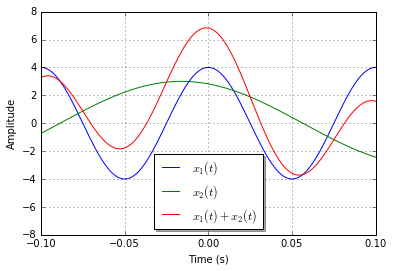

In [15]:
t = arange(-10,10,.001)
x1 = 4*cos(2*pi*10*t)
x2 = 3*cos(2*pi*3.45*t+pi/9)
plot(t,x1)
plot(t,x2)
plot(t,x1+x2)
grid()
xlabel(r'Time (s)')
ylabel(r'Amplitude')
legend((r'$x_1(t)$', r'$x_2(t)$', r'$x_1(t)+x_2(t)$'),loc='best',shadow=True)
xlim([-.1,.1]);

In [16]:
print('Power calculations: %3.2f, %3.2f, %3.2f' \
      % (var(x1),var(x2),var(x1+x2)))

Power calculations: 8.00, 4.50, 12.50


In [17]:
print('Theory: %3.2f, %3.2f, %3.2f' \
      % (4**2/2,3**2/2,4**2/2+3**2/2))

Theory: 8.00, 4.50, 12.50


# Fourier Series and Line Spectra Plotting

Being able to easily plot the line spectra of periodic signals will hopefully enhance your understanding. The module `ssd.py` contains the function `ssd.line_spectra()` for this purpose. The function assumes that the Fourier coefficients, $X_n$ are available for a real signal $x(t)$. The function plots line spectra as:
* The two-sided magnitude spectra
* The two-sided magnitude spectra in dB with an adjustable floor level in dB
* The two-sided phase spectra in radians
* The one-sided line spectra corresponding to the three cases listed immediately above
Examples are given below for the case of a simple pulse train and then for a trapezoidal pulse train. IN the case of the trapezoidal pulse train the underlying Fourier coefficients are obtained numerically using the FFT as described in the course notes.

A fundamental requirement in using `ssd.line_spectra()` is to beable to supply the coefficients starting with the DC term coefficient $X_0$ and moving up to the $N$th harmonic. Before plotting the pulse train line spectra I first describe a *helper* function for visualizing the pulse train waveform.

## Pulse Train

In [3]:
def pulse_train(Np,fs,tau,t0):
    """
    Generate a discrete-time approximation to a continuous-time
    pulse train signal. Amplitude values are [0,1]. Scale and offset
    later if needed.
    
    Inputs
    ------
     Np = number of periods to generate
     fs = samples per period
    tau = duty cycle
     t0 = pulse delay time relative to first rising edge at t = 0
    
    Return
    ------
    t = time axis array
    x = waveform
    
    Mark Wickert, January 2015
    """
    t = arange(0,Np*fs+1,1)/fs #time is normalized to make period T0 = 1.0
    x = zeros_like(t)
    # Using a brute force approach, just fill x with the sample values
    for k,tk in enumerate(t):
        if mod(tk-t0,1) <= tau and mod(tk-t0,1) >= 0:
            x[k] = 1
    return t,x

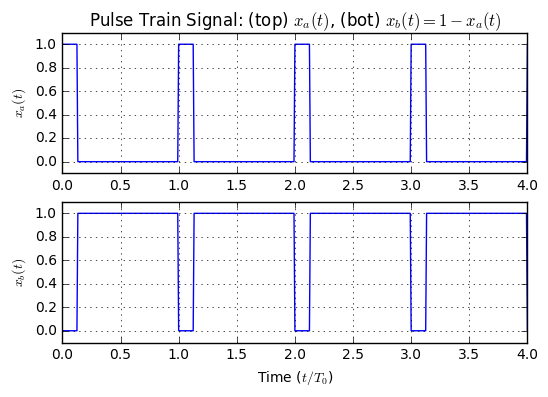

In [12]:
tau = 1/8; fs = 8*16; t0 = 0 # note t0 = tau/2
subplot(211)
t,x = pulse_train(4,fs,tau,t0)
plot(t,x) # Just a plot of xa(t)
ylim([-.1,1.1])
grid()
ylabel(r'$x_a(t)$')
title(r'Pulse Train Signal: (top) $x_a(t)$, (bot) $x_b(t) = 1-x_a(t)$');
subplot(212)
t,x = pulse_train(4,fs,tau,t0)
plot(t,1-x) # Note here y(t) = 1 - x(t), a special case of 
ylim([-.1,1.1]) # y(t) = A + B*x(t) in the notes
grid()
xlabel(r'Time ($t/T_0$)')
ylabel(r'$x_b(t)$');

## Example: Pulse Train Line Spectra

For the case of pulse train having the initial pulse starting at $t=0$, i.e.,
\begin{align}
    x(t) = \sum_{k=-\infty}^\infty A\cdot \Pi\left(\frac{t-\tau/2-kT_0}{\tau}\right),
\end{align}
the Fourier coefficient are given by
\begin{align}
    X_n = A\cdot\tau/T_0\cdot\text{sinc}(nf_0\tau)\cdot\exp(-j2\pi n f_0t_0) = A\cdot\tau/T_0\cdot\text{sinc}(nf_0\tau)\cdot\exp(-j\pi n f_0\tau)
\end{align}
where $f_0 = 1/T_0$ is the fundamental frequency and here $t_0 = \tau/2$.

Line spectra plotting is shown below for this case. If the pulse train should be shifted in time to some other orientation, then the phase plot will change, as the included $\exp(j2\pi n f_0 t_0)$ term will be different.

**Note:** The pulse train function define above is slightly different from the pulse train defined in the book and shown in mathematical form as $x(t)$ just above in this cell. The function `pulse_train()` has the first pulse starting exactly at $t=0$. To move the pule train right or left on the time axis, you can use the function parameter `t0`.

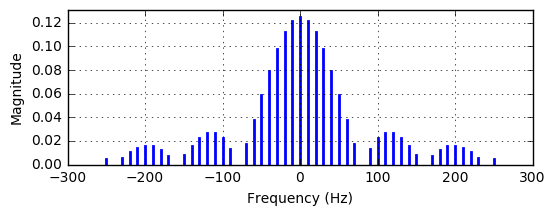

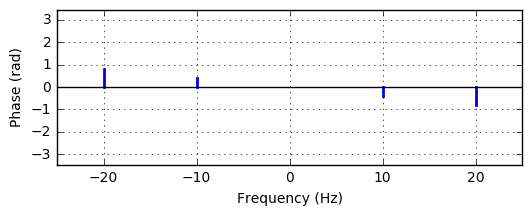

In [6]:
n = arange(0,25+1) # Get 0 through 25 harmonics
tau = 0.125; f0 = 1; A = 1;
Xn = A*tau*f0*sinc(n*f0*tau)*exp(-1j*2*pi*n*f0*tau/2)
figure(figsize=(6,2))
f = 10*n # Assume a fundamental frequency of 1 Hz so f = n
ssd.line_spectra(f,Xn,mode='mag',sides=2,fsize=(6,2))
#xlim([-25,25]);
#ylim([-50,10])
figure(figsize=(6,2))
ssd.line_spectra(f,Xn,mode='phase',fsize=(6,2))
xlim([-25,25]);

## Example: Trapezoidal Pulse

Consider the line spectra of a finite rise and fall time pulse train is of practical interest. The function `trap_pulse()` allows you first visualize one period of the trapezoidal pulse train, and then use this waveform in obtaining numerically the Fourier coefficients of this signal. PLotting the corresponding line spectra follows.

A point to be main is that by slowing down the edges (rise time/fall time) of the pulse train the amplitude of the harmonics falls off more rapidly. When considering the clock speed in todays PCs this can be a good thing as harmonic emission is an issue.

In [21]:
def trap_pulse(N,tau,tr):
    """
    xp = trap_pulse(N,tau,tr)
    
    Mark Wickert, January 2015
    """
    n = arange(0,N)
    t = n/N
    xp = zeros(len(t))
    # Assume tr and tf are equal
    T1 = tau + tr
    # Create one period of the trapezoidal pulse waveform
    for k in n:
        if t[k] <= tr:
            xp[k] = t[k]/tr
        elif (t[k] > tr and t[k] <= tau):
            xp[k] = 1
        elif (t[k] > tau and t[k] < T1):
            xp[k] = -t[k]/tr + 1 + tau/tr;
        else:
            xp[k] = 0
    return xp, t

Let $\tau = 1/8$ and $t_r = 1/20$:

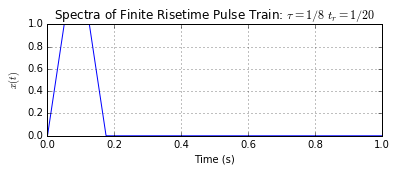

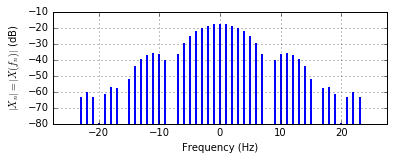

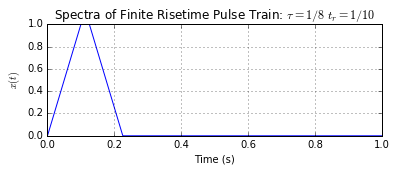

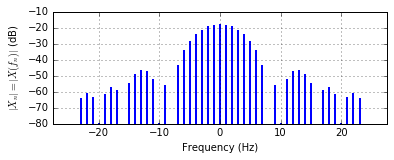

In [22]:
# tau = 1/8, tr = 1/20
N = 1024
xp,t = trap_pulse(N,1/8,1/20)
Xp = fft.fft(xp)
figure(figsize=(6,2))
plot(t,xp)
grid()
title(r'Spectra of Finite Risetime Pulse Train: $\tau = 1/8$ $t_r = 1/20$')
ylabel(r'$x(t)$')
xlabel('Time (s)')
f = arange(0,N/2)
ssd.line_spectra(f[0:25],Xp[0:25]/N,'magdB',floor_dB=-80,fsize=(6,2))
ylabel(r'$|X_n| = |X(f_n)|$ (dB)');
#% tau = 1/8, tr = 1/10
xp,t = trap_pulse(N,1/8,1/10)
Xp = fft.fft(xp)
figure(figsize=(6,2))
plot(t,xp)
grid()
title(r'Spectra of Finite Risetime Pulse Train: $\tau = 1/8$ $t_r = 1/10$')
ylabel(r'$x(t)$')
xlabel('Time (s)')
ssd.line_spectra(f[0:25],Xp[0:25]/N,'magdB',floor_dB=-80,fsize=(6,2))
ylabel(r'$|X_n| = |X(f_n)|$ (dB)');

With the edge speed slowed down it is clear that the harmonics drop off faster.

# Fourier Transforms

The Fourier transfrom definition is:
\begin{align}
    X(f) &= \int_{-\infty}^\infty x(t)\ e^{-j2\pi ft}\, dt \\
    x(t) &= \int_{-\infty}^\infty X(f)\, e^{j2\pi ft}\, df
\end{align}

A numerical approximation to the Fourier transform is possible using the FFT, or more conveniently using the function `freqz()` from the package `scipy.signal`. A helper function to abstract some of the digital signal processing details is `f, X = FT_approx(x,dt,Nfft)`:

In [3]:
def FT_approx(x,t,Nfft):
    '''
    Approximate the Fourier transform of a finite duration
    signal using scipy.signal.mfreqz()
    
    Inputs
    ------
       x = input signal array
       t = time array used to create x(t)
    Nfft = the number of frdquency domain points used to 
           approximate X(f) on the interval [fs/2,fs/2], where
           fs = 1/Dt. Dt being the time spacing in array t
    
    Return
    ------
    f = frequency axis array in Hz
    X = the Fourier transform approximation (complex)
    
    Mark Wickert, January 2015
    '''
    fs = 1/(t[1] - t[0])
    t0 = (t[-1]+t[0])/2 # time delay at center
    N0 = len(t)/2 # FFT center in samples
    f = arange(-1/2,1/2,1/Nfft)
    w, X = signal.freqz(x,1,2*pi*f)
    X /= fs # account for dt = 1/fs in integral
    X *= exp(-1j*2*pi*f*fs*t0)# time interval correction
    X *= exp(1j*2*pi*f*N0)# FFT time interval is [0,Nfft-1]
    F = f*fs
    return F, X

## Example: Rectangular Pulse

As as simple starting point example, consider $x(t) = \Pi(t\tau)$. The well known result for the Fourier transfrom (FT) is:
\begin{align}
    X(f) = \mathcal{F}\left\{\Pi\left(\frac{t}{\tau}\right)\right\} = \tau\,\text{sinc}(f\tau)
\end{align}
We now use the above defined `FT_approx()` to obtain a numerical approximation to the FT of the rectangular pulse.

**Tips:**
* Make sure the signal is well contained on the time interval used to generate $x(t)$
* Make sure the sampling rate, one over the sample spacing, is adequate to represent the signal spectrum
* From sampling theory, the reange of frequencies represented by the spectrum estimate will be $f_s/2 \leq f < f_s/2$

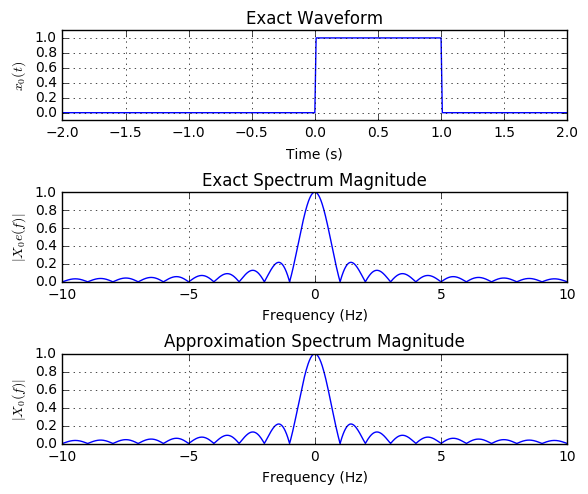

In [4]:
fs = 100 # sampling rate in Hz
tau = 1
t = arange(-5,5,1/fs)
x0 = ssd.rect(t-.5,tau)
figure(figsize=(6,5))
subplot(311)
plot(t,x0)
grid()
ylim([-0.1,1.1])
xlim([-2,2])
title(r'Exact Waveform')
xlabel(r'Time (s)')
ylabel(r'$x_0(t)$');

# FT Exact Plot
fe = arange(-10,10,.01)
X0e = tau*sinc(fe*tau)
subplot(312)
plot(fe,abs(X0e))
#plot(f,angle(X0))
grid()
xlim([-10,10])
title(r'Exact Spectrum Magnitude')
xlabel(r'Frequency (Hz)')
ylabel(r'$|X_0e(f)|$');

# FT Approximation Plot
f,X0 = FT_approx(x0,t,4096)
subplot(313)
plot(f,abs(X0))
#plot(f,angle(X0))
grid()
xlim([-10,10])
title(r'Approximation Spectrum Magnitude')
xlabel(r'Frequency (Hz)')
ylabel(r'$|X_0(f)|$');
tight_layout()

## Example: Text Problem 2.31a Drill Down

In this problem you are given
\begin{align}
    x_1(t) = \Pi\left(\frac{t+1/2}{1}\right) - \Pi\left(\frac{t-1/2}{1}\right)
\end{align}
The Fourier transfrom of this signal can be found using *linearity* and the *time delay* theorems.
\begin{align}
    X_1(f) &= \mathcal{F}\left\{\Pi\left(\frac{t+1/2}{1}\right) - \Pi\left(\frac{t-1/2}{1}\right)\right\} \\
    &= \text{sinc}(f)\cdot\left[e^{j2\pi f\cdot 1/2} - e^{-j2\pi f\cdot 1/2}\right]\times\frac{2j}{2j} \\
    &= 2j\ \text{sinc}(f)\cdot\sin(\pi f)
\end{align}

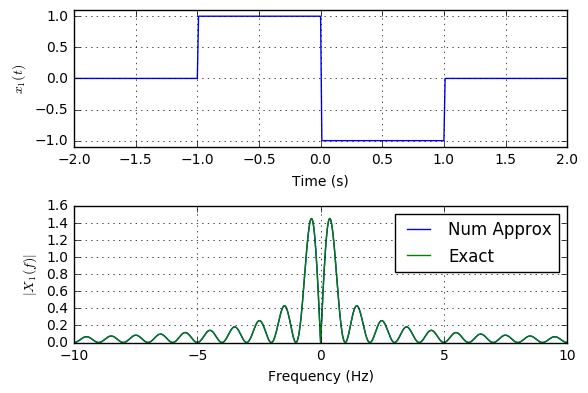

In [6]:
fs = 100
t = arange(-5,5,1/fs)
x1 = ssd.rect(t+1/2,1)-ssd.rect(t-1/2,1)
subplot(211)
plot(t,x1)
grid()
ylim([-1.1,1.1])
xlim([-2,2])
xlabel(r'Time (s)')
ylabel(r'$x_1(t)$');
fe = arange(-10,10,.01)
X1e = 2*1j*sinc(fe)*sin(pi*fe)
f,X1 = FT_approx(x1,t,4096)
subplot(212)
plot(f,abs(X1))
plot(fe,abs(X1e))
#plot(f,angle(X1))
legend((r'Num Approx',r'Exact'),loc='best')
grid()
xlim([-10,10])
xlabel(r'Frequency (Hz)')
ylabel(r'$|X_1(f)|$');
tight_layout()

* Notice the numerical approximation and exact spectral plots overlay one another

## Example: Modulation Theorem

Consider the modulation theorem, which is extremely important to communications theory:
\begin{align}
    y(t) &= x(t)\cdot\cos(2\pi f_0 t) \\
    Y(f) &= \frac{1}{2}\left[X(f-f_0) + X(f+f_0)\right]
\end{align}
Here we will use a triangle pulse for $x(t)$:

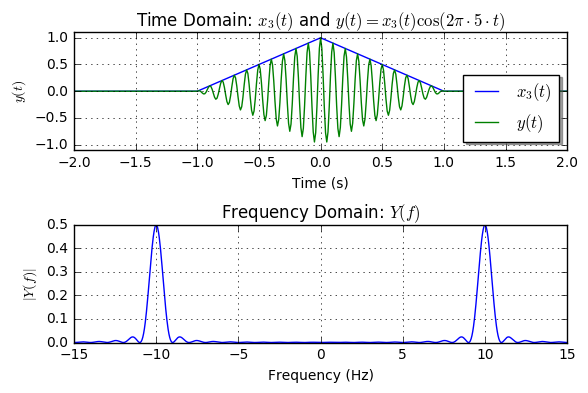

In [7]:
fs = 100 # sampling rate in Hz
tau = 1
t = arange(-5,5,1/fs)
x3 = ssd.tri(t,tau)
y = x3*cos(2*pi*10*t)
subplot(211)
plot(t,x3)
plot(t,y)
grid()
ylim([-1.1,1.1])
xlim([-2,2])
legend((r'$x_3(t)$', r'$y(t)$'),loc='lower right',shadow=True)
title(r'Time Domain: $x_3(t)$ and $y(t)=x_3(t)\cos(2\pi\cdot 5\cdot t)$')
xlabel(r'Time (s)')
ylabel(r'$y(t)$');
f,Y = FT_approx(y,t,4096)
subplot(212)
plot(f,abs(Y))
#plot(f,angle(X0))
grid()
title(r'Frequency Domain: $Y(f)$')
xlim([-15,15])
xlabel(r'Frequency (Hz)')
ylabel(r'$|Y(f)|$');
tight_layout()

## Example: Representing a Bandlimited Signal

We know that in theory a bandlimited signal can only be generated from a signal having infinite duration. Specifically, a signal with rectangular spectrum has Fourier transfrom pair:
\begin{align}
    x(t) = 2W\text{sinc}(2Wt) \overset{\mathcal{F}}{\Leftrightarrow} \Pi\left(\frac{f}{2W}\right) = X(f)
\end{align}
In a simulation we expect to have troubles modeling the finite duration aspects of the signal.

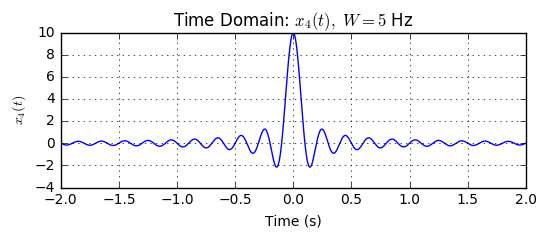

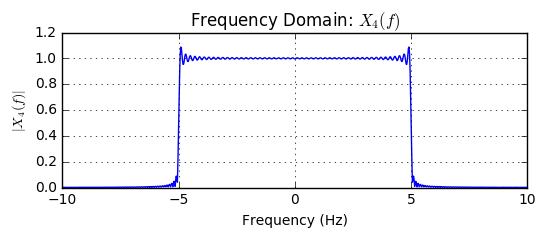

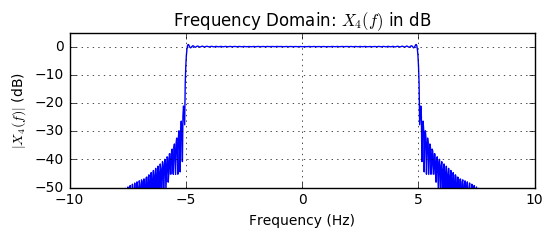

In [4]:
fs = 100 # sampling rate in Hz
W = 5
t = arange(-5,5,1/fs)
x4 = 2*W*sinc(2*W*t)
figure(figsize=(6,2))
plot(t,x4)
grid()
#ylim([-1.1,1.1])
xlim([-2,2])
title(r'Time Domain: $x_4(t),\ W = 5$ Hz')
xlabel(r'Time (s)')
ylabel(r'$x_4(t)$');
f,X4 = FT_approx(x4,t,4096)
figure(figsize=(6,2))
plot(f,abs(X4))
grid()
title(r'Frequency Domain: $X_4(f)$')
xlim([-10,10])
xlabel(r'Frequency (Hz)')
ylabel(r'$|X_4(f)|$');
figure(figsize=(6,2))
plot(f,20*log10(abs(X4)))
grid()
title(r'Frequency Domain: $X_4(f)$ in dB')
ylim([-50,5])
xlim([-10,10])
xlabel(r'Frequency (Hz)')
ylabel(r'$|X_4(f)|$ (dB)');

**Note:** The dB version (last plot) reveals that the first sidelobes of the spectrum are only down ~21dB. Increasing the length of the time window will not help. The spectral side lobes will become more tightly packed, but the first sidelobe will still be down only 21dB. With other pulse shapes in the time domain, i.e., note simply a truncted $\text{sinc}()$ function reduced sidelobes can be obtained.

# Convolution

* The convolution of two signals $x_1(t)$ and $x_2(t)$ is defined as
\begin{align}
	x(t) &= x_1(t)\ast x_2(t) = \int_{-\infty}^\infty x_1(\lambda)x_2(t-\lambda)\, d\lambda \\
	&= x_2(t)\ast x_1(t) = \int_{-\infty}^\infty x_2(\lambda)x_1(t-\lambda)\, d\lambda
\end{align}
* A special convolution case is $\delta(t-t_0)$
\begin{align}
		\delta(t-t_0)\ast x(t) &= \int_{-\infty}^\infty \delta(\lambda-t_0)x(t-\lambda)\, d\lambda \\
		&= x(t-\lambda)\big|_{\lambda=t_0} = x(t-t_0)
\end{align}
You can experiment with the convolution integral numerically using `ssd.conv_integral()` found in the module `ssd.py`.

Output support: (-4.00, +4.00)


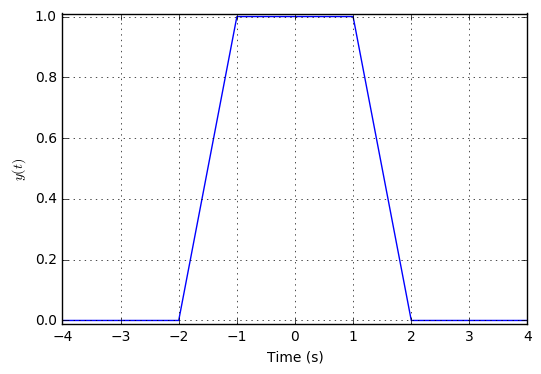

In [5]:
t = arange(-2,2.001,.001)
p1 = ssd.rect(t,1)
p2 = ssd.rect(t,3)
y,ty = ssd.conv_integral(p1,t,p2,t)
plot(ty,y)
ylim([-.01,1.01])
grid()
xlabel(r'Time (s)')
ylabel(r'$y(t)$');

For convolutions involving semi-infinite signals, such as $u(t)$, you can tell `ssd.conv_integral()` about this via the optional extent argument. See the function help using
```python
ssd.conv_integral?
```

Output support: (-2.00, +6.99)


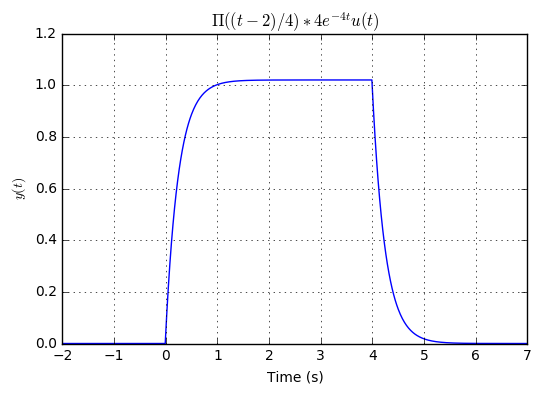

In [6]:
# Consider a pulse convolved with an exponential ('r' type extent)
tx = arange(-1,8,.01)
x = ssd.rect(tx-2,4) # pulse starts at t = 0
h = 4*exp(-4*tx)*ssd.step(tx)
y,ty = ssd.conv_integral(x,tx,h,tx,extent=('f','r')) # note extents set
plot(ty,y) # expect a pulse charge and discharge waveform
grid()
title(r'$\Pi((t-2)/4)\ast 4 e^{-4t} u(t)$')
xlabel(r'Time (s)')
ylabel(r'$y(t)$');

# Spectrum of PN Sequence

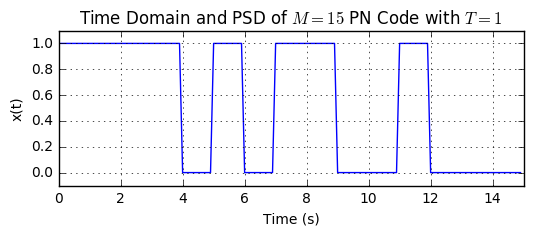

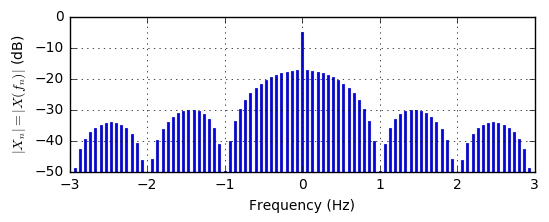

In [7]:
x_PN4 = ssd.m_seq(4)
x = signal.lfilter(ones(10),1,ssd.upsample(x_PN4,10))
t = arange(0,len(x))/10
figure(figsize=(6,2))
plot(t,x);
title(r'Time Domain and PSD of $M=15$ PN Code with $T = 1$')
xlabel(r'Time (s)')
ylabel(r'x(t)')
axis([0,15,-.1,1.1]);
grid()
X = fft.fft(x,10*15) # 10 samples/bit so 150 samples/period
f = arange(0,7*10)/15 # harmonics spaced by 1/(15*T) = 1/15
ssd.line_spectra(f[0:45],abs(X[0:45])/150,'magdB',floor_dB=-50,fsize=(6,2))
xlim([-3,3])
ylabel(r'$|X_n| = |X(f_n)|$ (dB)');

In [8]:
import digitalcom as dc
y_PN4_bits = ssd.PN_gen(10000,4)
# Convert to waveform level shifted to +/-1 amplitude
y = 2*signal.lfilter(ones(10),1,ssd.upsample(y_PN4_bits,10))-1
# Find the time averaged autocorrelation function normalized
# to have a peak amplitude of 1
Ry,tau = dc.xcorr(y,y,200)
# We know Ry is real
Ry = Ry.real

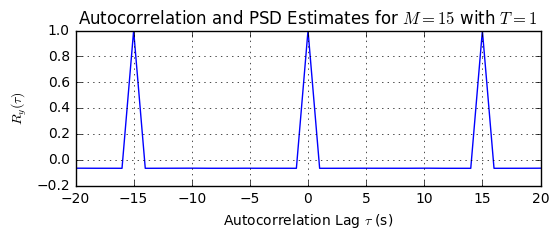

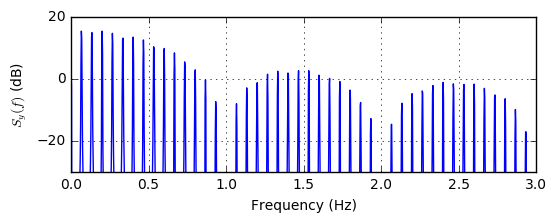

In [9]:
tau_s = tau/10
figure(figsize=(6,2))
plot(tau_s,Ry)
title(r'Autocorrelation and PSD Estimates for $M=15$ with $T = 1$')
xlabel(r'Autocorrelation Lag $\tau$ (s)')
ylabel(r'$R_y(\tau)$')
grid();
figure(figsize=(6,2))
psd(y,2**12,10)
xlabel(r'Frequency (Hz)')
ylabel(r'$S_y(f)$ (dB)')
xlim([0,3]);
ylim([-30,20]);

### Lab Tip: PN Generator Coded at the Bit Level
In Lab 2 of ECE 4670 a C/C++ version of a PN generator is implemented to run the ARM `mbed` LPC 1768 microcontroller (https://www.sparkfun.com/products/9564). At the heart of this code is:
```C
// Globals defined as unsigned int
tap1 -= 1;
tap2 -= 1;
mask1 = 0x1 << (tap1);
mask2 = 0x1 << (tap2);
bit = 0x0;
sync = 0x0;

void gen_PN() {
    my_pin5 = bit;
    my_pin6 = synch_bit;
    led2 = bit;
    led3 = synch_bit;
    if (clk_state == 0x1)
    {
    // Advance m-sequence generator by one bit
    // XOR tap1 and tap2 SR values and feedback to input
        fb = ((sr & mask1)>> tap1) ^ ((sr & mask2) >> tap2);
        sr = (sr << 1) + fb;
        bit = sr & 0x1;
        // Use random number generator in place of m-sequence bits
        if (DIP_sw4)
        {
            bit = rand_int() & 0x1;
        }
        clk_state = 0x0;
        // See if all 1's condition exists in SR
        if ((sr & synch) == synch) {
            synch_bit = 0x1;
        }
        else
        {
            synch_bit = 0x0;  
        }
    }
    else
    {
        if (DIP_sw1) bit = !bit;
        clk_state = 0x1;
    }
}
```
The data type is `unsigned int` which on the mbed is `uint16_t` which is an unsigned 16-bit integer. A single unsigned integer is used as a 16-bit shift register with the LSB, furthest to the right, used to represent the first register stage. The shift register is advanced using a left shift `<<` bitwise operation. We can code this Python almost directly, as shown below.

In [10]:
def bitwise_PN(sr,tap1,tap2,Nstage):
    '''
    Implement a PN generator using bitwise manipulation for
    the shift register. The LSB holds b0 and bits are shifted left.
              +----+----+----+----+----+----+----+
         sr = |bM-1| .. |bM-k| .. | b2 | b1 | b0 |
              +----+----+----+----+----+----+----+
                 |         |
    Feedback:(tap1-1)   (tap2-1)    Shift left using <<
    
    Mark Wickert February 2017
    '''
    tap1 -= 1 # since first SR index is zero
    tap2 -= 1 # since first SR index is zero
    mask1 = 0x1 << (tap1) # to select bit of interest
    mask2 = 0x1 << (tap2) # to select bit of interest
    sync = 2**Nstage - 1
    
    # Advance m-sequence generator by one bit
    # XOR tap1 and tap2 SR values and feedback to input
    fb = ((sr & mask1)>> tap1) ^ ((sr & mask2) >> tap2)
    sr = (sr << 1) + fb
    sr = sr & sync # set MSBs > Nstage to 0
    bit = sr & 0x1 # output LSB from SR 
    # See if all 1's condition exits in SR, if so output a synch pulse
    if ((sr & sync) == sync):
        sync_bit = 0x1
    else:
        sync_bit = 0x0  
    print('output = %d, sr contents = %s, sync bit = %d' \
         % (bit, binary(sr, Nstage), sync_bit))
    return sr

# A simple binary format display function which shows
# leading zeros to a fixed bit width
def binary(num, length=8):
    return format(num, '#0{}b'.format(length + 2))

In [11]:
# sr initial condition
sr = 0b1

In [12]:
Nout = 20
x_out = zeros(Nout)
s_out = zeros(Nout)
for k in range(Nout):
    sr = bitwise_PN(sr,3,2,3)
    x_out[k] = sr & 0x1 # extract bit 0
    s_out[k] = 1 if sr == (2**3 - 1) else 0 # detect all 1's

output = 0, sr contents = 0b010, sync bit = 0
output = 1, sr contents = 0b101, sync bit = 0
output = 1, sr contents = 0b011, sync bit = 0
output = 1, sr contents = 0b111, sync bit = 1
output = 0, sr contents = 0b110, sync bit = 0
output = 0, sr contents = 0b100, sync bit = 0
output = 1, sr contents = 0b001, sync bit = 0
output = 0, sr contents = 0b010, sync bit = 0
output = 1, sr contents = 0b101, sync bit = 0
output = 1, sr contents = 0b011, sync bit = 0
output = 1, sr contents = 0b111, sync bit = 1
output = 0, sr contents = 0b110, sync bit = 0
output = 0, sr contents = 0b100, sync bit = 0
output = 1, sr contents = 0b001, sync bit = 0
output = 0, sr contents = 0b010, sync bit = 0
output = 1, sr contents = 0b101, sync bit = 0
output = 1, sr contents = 0b011, sync bit = 0
output = 1, sr contents = 0b111, sync bit = 1
output = 0, sr contents = 0b110, sync bit = 0
output = 0, sr contents = 0b100, sync bit = 0


(0, 1.1)

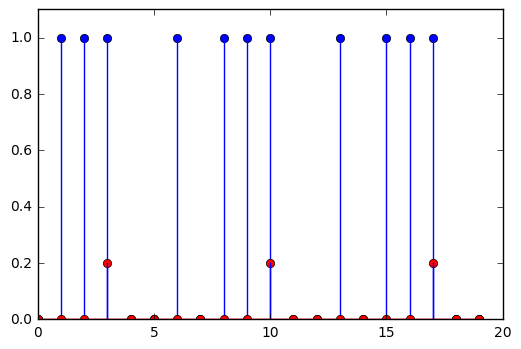

In [13]:
stem(x_out)
stem(0.2*s_out,markerfmt = 'ro')
ylim([0,1.1])

## Cross Correlation and Signal Delay

The idea of the autocorrelation function can be extended to the cross correlation, that is the correlation or likeness between two signals, say $x(t)$ and $y(t)$. Define
\begin{align}
    R_{xy}(\tau) = \langle x(t)y(t+\tau)\rangle = \lim_{T\rightarrow\infty} \frac{1}{2T}\int_{-T}^T x(t)y(t+\tau)\, dt
\end{align}
Consider a simulation example using `dc.xcorr(x,t,lags)`:

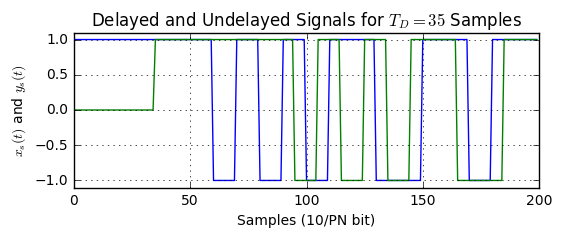

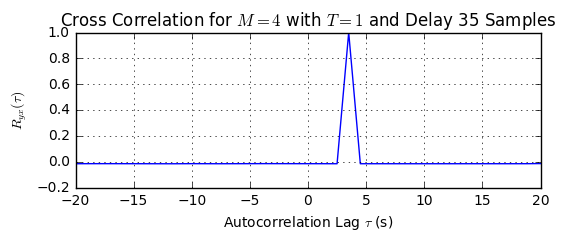

In [14]:
import digitalcom as dc
x_PN4_bits = ssd.PN_gen(10000,6)
# Convert to waveform level shifted to +/-1 amplitude
x_s = 2*signal.lfilter(ones(10),1,ssd.upsample(x_PN4_bits,10))-1
# Form a delayed version of x_S
T_D = 35 # 35 sample delay
y_s = signal.lfilter(concatenate((zeros(T_D),array([1]))),1,x_s)
figure(figsize=(6,2))
plot(x_s[:200])
plot(y_s[:200])
ylim([-1.1,1.1])
title(r'Delayed and Undelayed Signals for $T_D = 35$ Samples')
xlabel(r'Samples (10/PN bit)')
ylabel(r'$x_s(t)$ and $y_s(t)$')
grid();
# Find the time averaged autocorrelation function normalized
# to have a peak amplitude of 1
Ryx,tau = dc.xcorr(y_s,x_s,200) #note order change
# We know Ryx is real
Ryx = Ryx.real
tau_s = tau/10
figure(figsize=(6,2))
plot(tau_s,Ryx)
title(r'Cross Correlation for $M=4$ with $T = 1$ and Delay 35 Samples')
xlabel(r'Autocorrelation Lag $\tau$ (s)')
ylabel(r'$R_{yx}(\tau)$')
grid();

# Spectral Containment Bandwidth (text problem 2.55)

In text problem 2.55 you are asked to find the 90% energy contain bandwidth of a signal $x_i(t)$. Specifically you are to find the lowpass or one-sided bandwidth of a baseband signal such that 90% of the total signal energy is contained in the bandwidth, $B_{90}$. You obtain $B_{90}$ by solving the following equation
\begin{align}
    0.9 = \frac{0.9 E_\text{total}}{E_\text{total}} = \frac{\int_{-B_{90}}^{B_{90}} G(f) df}{\int_{-\infty}^\infty G(f) df} = \frac{2\int_0^{B_{90}} G(f) df}{2\int_0^\infty G(f) df} = \frac{\int_0^{B_{90}} G(f) df}{\int_0^\infty G(f) df},
\end{align}
where $G(f) = |X_i(f)|^2$ is the energy spectral density of $x_i(t)$.

For parts (c) and (d) the problem states you need to perform numerical integration.

## Example:

In an exalier example found in this notebook I found the Fourier transform of
\begin{align}
    x(t) = \Pi\left(\frac{t-\tau/2}{\tau}\right) - \Pi\left(\frac{t+\tau/2}{\tau}\right)
\end{align}
to be
\begin{align}
    X(f) &= 2j\ \text{sinc}(f\tau)\cdot\sin(\pi f\tau)
\end{align}
Note I have modified the problem to now have pulse width $\tau$ to better match the homework problem where $\tau$ is a variable.

The energy spectral density is
\begin{align}
    G(f) = 4\, \text{sinc}^2(f\tau)\cdot\sin^2(\pi f\tau)
\end{align}

I convenient way to numerically integrate $G(f)$ is using simple reactangular partitions, but making sure that $\Delta f$ is small relative to the changes in $G(f)$. Since you do not know what the value of $\tau$ you consider a *normalized frequency* variable $f_n = f\tau$ in the analysis. The rest of the steps are:

1. Sweep $G(f_n)$ using an array `fn` running from zero to $f_n$ large enough to insure that $G(f_n)$ is very small relative to it largest value. In Python this is just filling an array, `Gn` with the functional values.
2. Form a new array which contains the cumulative sum of the values in `Gn`, say `Gn_cumsum = cumsum(Gn)`. Aso form the sum of the array values, i.e., `Gn_tot = sum(Gn)`
3. Plot the ratio of ``Gn_cumsum/Gn_sum` versus `fn`. The curve should start at zero and climb to one as $f_n$ becomes large. The value of $f_n$ where the curve crosses through 0.9 is the 90% containment bandwidth.

**Note:** You might notice that $\Delta f$, which is needed in the rectangular integration formula was never used. Why? In the calculation of the cumulative sum and the calculation of the total, both should include $\Delta f$, hence in the ration the values cancel out. Nice!

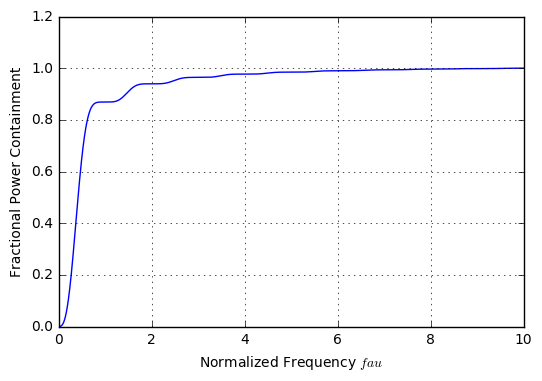

In [18]:
fn = arange(0,10,.001)
Gn = 4*sinc(fn)**2 * sin(pi*fn)**2
Gn_cumsum = cumsum(Gn)
Gn_tot = sum(Gn)
plot(fn,Gn_cumsum/Gn_tot)
grid()
#ylim([.85, .95]) # zoom in
xlabel('Normalized Frequency $f\tau$')
ylabel('Fractional Power Containment');

In [36]:
fn_idx = find(abs(Gn_cumsum/Gn_tot - 0.9)< 0.0005)
fn_idx

array([1446, 1447, 1448, 1449, 1450])

In [19]:
print('The normalized 90 percent containment bandwidth is %2.2f Hz-s.' \
      % fn[1448])

The normalized 90 percent containment bandwidth is 1.45 Hz-s.


# Filter Analysis

To facilitate the performance analysis of both discrete-time and continuous-time filters, the functions `freqz_resp()` and `freqs_resp()` are available (definitions below, respectively). With these functions you can quickly move from *z*-domain or *s*-domain rational system function coefficients to visualization of the filter frequency response
* Magnitude
* Magnitude in dB
* Phase in radians
* Group delay in samples or seconds (digital filter)
* Group delay in seconds (analog filter)

In [38]:
def freqz_resp(b,a=[1],mode = 'dB',fs=1.0,Npts = 1024,fsize=(6,4)):
    """
    A method for displaying digital filter frequency response magnitude,
    phase, and group delay. A plot is produced using matplotlib

    freq_resp(self,mode = 'dB',Npts = 1024)

    A method for displaying the filter frequency response magnitude,
    phase, and group delay. A plot is produced using matplotlib

    freqs_resp(b,a=[1],Dmin=1,Dmax=5,mode = 'dB',Npts = 1024,fsize=(6,4))

        b = ndarray of numerator coefficients
        a = ndarray of denominator coefficents
     Dmin = start frequency as 10**Dmin
     Dmax = stop frequency as 10**Dmax
     mode = display mode: 'dB' magnitude, 'phase' in radians, or 
            'groupdelay_s' in samples and 'groupdelay_t' in sec, 
            all versus frequency in Hz
     Npts = number of points to plot; defult is 1024
    fsize = figure size; defult is (6,4) inches
    
    Mark Wickert, January 2015
    """
    f = np.arange(0,Npts)/(2.0*Npts)
    w,H = signal.freqz(b,a,2*np.pi*f)
    plt.figure(figsize=fsize)
    if mode.lower() == 'db':
        plt.plot(f*fs,20*np.log10(np.abs(H)))
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Gain (dB)')
        plt.title('Frequency Response - Magnitude')

    elif mode.lower() == 'phase':
        plt.plot(f*fs,np.angle(H))
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Phase (rad)')
        plt.title('Frequency Response - Phase')

    elif (mode.lower() == 'groupdelay_s') or (mode.lower() == 'groupdelay_t'):
        """
        Notes
        -----

        Since this calculation involves finding the derivative of the
        phase response, care must be taken at phase wrapping points 
        and when the phase jumps by +/-pi, which occurs when the 
        amplitude response changes sign. Since the amplitude response
        is zero when the sign changes, the jumps do not alter the group 
        delay results.
        """
        theta = np.unwrap(np.angle(H))
        # Since theta for an FIR filter is likely to have many pi phase
        # jumps too, we unwrap a second time 2*theta and divide by 2
        theta2 = np.unwrap(2*theta)/2.
        theta_dif = np.diff(theta2)
        f_diff = np.diff(f)
        Tg = -np.diff(theta2)/np.diff(w)
        max_Tg = np.max(Tg)
        #print(max_Tg)
        if mode.lower() == 'groupdelay_t':
            max_Tg /= fs
            plt.plot(f[:-1]*fs,Tg/fs)
            plt.ylim([0,1.2*max_Tg])
        else:
            plt.plot(f[:-1]*fs,Tg)
            plt.ylim([0,1.2*max_Tg])
        plt.xlabel('Frequency (Hz)')
        if mode.lower() == 'groupdelay_t':
            plt.ylabel('Group Delay (s)')
        else:
            plt.ylabel('Group Delay (samples)')
        plt.title('Frequency Response - Group Delay')
    else:
        s1 = 'Error, mode must be "dB", "phase, '
        s2 = '"groupdelay_s", or "groupdelay_t"'
        print(s1 + s2)

In [39]:
def freqs_resp(b,a=[1],Dmin=1,Dmax=5,mode = 'dB',Npts = 1024,fsize=(6,4)):
    """
    A method for displaying analog filter frequency response magnitude,
    phase, and group delay. A plot is produced using matplotlib

    freqs_resp(b,a=[1],Dmin=1,Dmax=5,mode='dB',Npts=1024,fsize=(6,4))

        b = ndarray of numerator coefficients
        a = ndarray of denominator coefficents
     Dmin = start frequency as 10**Dmin
     Dmax = stop frequency as 10**Dmax
     mode = display mode: 'dB' magnitude, 'phase' in radians, or 
            'groupdelay', all versus log frequency in Hz
     Npts = number of points to plot; defult is 1024
    fsize = figure size; defult is (6,4) inches
    
    Mark Wickert, January 2015
    """
    f = np.logspace(Dmin,Dmax,Npts)
    w,H = signal.freqs(b,a,2*np.pi*f)
    plt.figure(figsize=fsize)
    if mode.lower() == 'db':
        plt.semilogx(f,20*np.log10(np.abs(H)))
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Gain (dB)')
        plt.title('Frequency Response - Magnitude')

    elif mode.lower() == 'phase':
        plt.semilogx(f,np.angle(H))
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Phase (rad)')
        plt.title('Frequency Response - Phase')

    elif mode.lower() == 'groupdelay':
        """
        Notes
        -----

        See freqz_resp() for calculation details.
        """
        theta = np.unwrap(np.angle(H))
        # Since theta for an FIR filter is likely to have many pi phase
        # jumps too, we unwrap a second time 2*theta and divide by 2
        theta2 = np.unwrap(2*theta)/2.
        theta_dif = np.diff(theta2)
        f_diff = np.diff(f)
        Tg = -np.diff(theta2)/np.diff(w)
        max_Tg = np.max(Tg)
        #print(max_Tg)
        plt.semilogx(f[:-1],Tg)
        plt.ylim([0,1.2*max_Tg])
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Group Delay (s)')
        plt.title('Frequency Response - Group Delay')
    else:
        print('Error, mode must be "dB" or "phase or "groupdelay"')

## Example: Simple Approximation to an Ideal Filter

## Example: Discrete-Time Chebyshev Type I Bandpass Filter

In [40]:
b,a = signal.cheby1(5,.1,2*array([250,300])/1000,btype='bandpass')

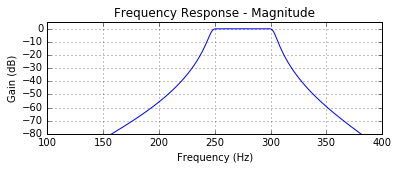

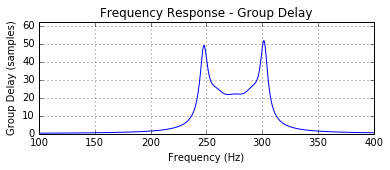

In [41]:
freqz_resp(b,a,mode='dB',fs=1000,fsize=(6,2))
grid()
ylim([-80,5]);
xlim([100,400]);
freqz_resp(b,a,mode='groupdelay_s',fs=1000,fsize=(6,2))
grid()
xlim([100,400]);

## Example: Continuous-Time Bessel Bandpass Filter

In [42]:
bc,ac = signal.bessel(7,2*pi*array([10.0,50.0])*1e6,btype='bandpass',analog=True)
#bc,ac = signal.cheby1(7,1,2*pi*array([10.0,15.0])*1e6,btype='bandpass',analog=True)

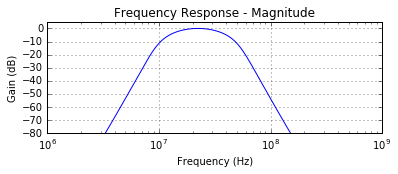

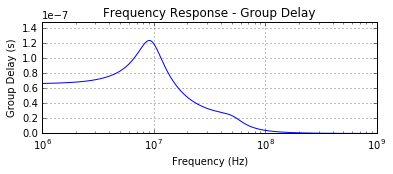

In [43]:
freqs_resp(bc,ac,6,9,mode='dB',fsize=(6,2))
grid()
ylim([-80,5]);
#xlim([5e6,3e7])
freqs_resp(bc,ac,6,9,mode='groupdelay',fsize=(6,2))
grid()
#xlim([5e6,3e7])

## Second-Order Butterworth Lowpass Response

Consider a 3rd-order analog Butterworth is the $s$-domain having transfer function $H(s)$. Using the `scipy.signal` function `butter()` we find the coefficients to the rational transfer function of the form:
\begin{align}
    H(s) = \frac{\sum_{n=0}^M b_n s^n}{\sum_{n=0}^N a_n s^n}
\end{align}

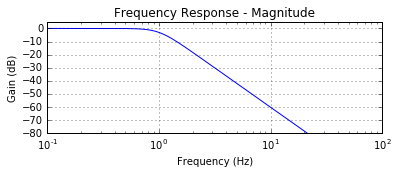

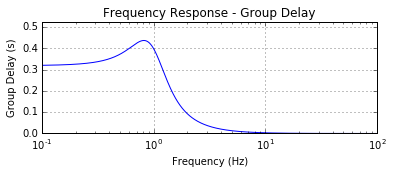

In [44]:
b3,a3 = signal.butter(3,2*pi*1,analog=True)
freqs_resp(b3,a3,-1,2,mode='dB',fsize=(6,2))
grid()
ylim([-80,5]);
#xlim([5e6,3e7])
freqs_resp(b3,a3,-1,2,mode='groupdelay',fsize=(6,2))
grid()
#xlim([5e6,3e7])

### Obtaining the Step Response via Simulation

Time domain simulation of continuous time system can be performed using the `signal.lsim()` function. You have to make sure the time step is sufficiently small relative to the filter bandwidth.

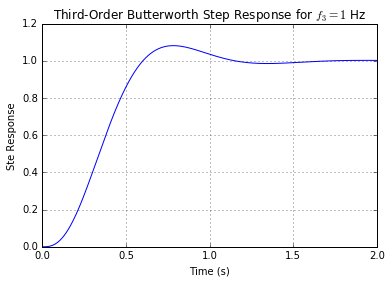

In [45]:
t = arange(0,2,.0001)
xs = ssd.step(t)
tout,ys,x_state = signal.lsim((b3,a3),xs,t)
plot(t,ys)
title(r'Third-Order Butterworth Step Response for $f_3 = 1$ Hz')
ylabel(r'Ste Response')
xlabel(r'Time (s)')
grid();